In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForMaskedLM
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import logging
from tqdm.auto import tqdm
import os
import matplotlib.pyplot as plt
import json
import datetime
from typing import Dict, List
import warnings
#from google.colab import drive
torch.cuda.empty_cache()

CUDA_LAUNCH_BLOCKING=1

#drive.mount('/content/drive')
warnings.filterwarnings("ignore")

/Users/perrineqhn/Desktop/M2/S1/Documents_Structure/Projet/Artificial_Learner/artificial_learner/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Classe C4200MDataset
Cette classe est une sous-classe de Dataset de PyTorch et est utilisÃ©e pour prÃ©parer un ensemble de donnÃ©es destinÃ© Ã  entraÃ®ner un modÃ¨le BERT Ã  gÃ©nÃ©rer des erreurs Ã  partir de textes corrects.

FonctionnalitÃ©s principales :
- Initialisation (__init__) :

    - ParamÃ¨tres :

        - clean_texts : liste des textes corrects qui serviront d'entrÃ©es au modÃ¨le.
        - error_texts : liste des textes contenant des erreurs correspondants aux textes corrects.
        - tokenizer : tokenizer BERT utilisÃ© pour convertir les textes en tokens.
        - max_length : longueur maximale des sÃ©quences aprÃ¨s tokenisation (par dÃ©faut 512).

    - Processus :

        - Stocke les textes corrects et les textes avec erreurs.
        - Initialise le tokenizer et la longueur maximale.

- MÃ©thode __len__ :
    - Retourne le nombre total d'Ã©chantillons dans le jeu de donnÃ©es, basÃ© sur la longueur de la liste des textes corrects.

- MÃ©thode __getitem__ :
    - ParamÃ¨tre :
        - idx : index de l'Ã©chantillon Ã  rÃ©cupÃ©rer.
    - Processus :

        - RÃ©cupÃ¨re le texte correct et le texte avec erreurs Ã  l'index spÃ©cifiÃ©.
        - Tokenisation du texte correct :
            - Utilise le tokenizer BERT pour convertir le texte en une sÃ©quence de tokens.
            - Applique un padding pour atteindre la max_length.
            - Tronque si le texte dÃ©passe la longueur maximale.
            - GÃ©nÃ¨re les tenseurs input_ids et attention_mask pour l'entrÃ©e du modÃ¨le.

        - Tokenisation du texte avec erreurs :
            - MÃªme processus que pour le texte correct, mais sur le texte contenant des erreurs.
            - Les input_ids rÃ©sultants serviront de labels lors de l'entraÃ®nement.

    - Retourne :
        - Un dictionnaire contenant :
            - 'input_ids' : les ids des tokens du texte correct (entrÃ©e du modÃ¨le).
            - 'attention_mask' : le masque d'attention indiquant les tokens Ã  considÃ©rer.
            - 'labels' : les ids des tokens du texte avec erreurs (cible pour l'apprentissage).

In [2]:
class C4200MDataset(Dataset):
    def __init__(self, clean_texts: List[str], error_texts: List[str], tokenizer, max_length: int = 512):
        """
        Dataset pour le corpus C4200M qui apprend Ã  gÃ©nÃ©rer des erreurs Ã  partir de textes corrects
        Args:
            clean_texts: Liste des textes corrects (input)
            error_texts: Liste des textes avec erreurs (output/target)
            tokenizer: Tokenizer BERT
            max_length: Longueur maximale des sÃ©quences
        """
        self.clean_texts = clean_texts  # textes corrects comme input
        self.error_texts = error_texts  # textes avec erreurs comme cible
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.clean_texts)

    def __getitem__(self, idx):
        clean_text = self.clean_texts[idx]
        error_text = self.error_texts[idx]

        # Tokenisation du texte correct (input)
        clean_encoding = self.tokenizer(
            clean_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Tokenisation du texte avec erreurs (target)
        error_encoding = self.tokenizer(
            error_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': clean_encoding['input_ids'].squeeze(),  # texte correct
            'attention_mask': clean_encoding['attention_mask'].squeeze(),
            'labels': error_encoding['input_ids'].squeeze()  # texte avec erreurs comme cible
        }

In [3]:
class TrainingTracker:
    """Classe pour suivre et enregistrer les mÃ©triques d'entraÃ®nement."""

    def __init__(self, output_dir: str):
        """
        Initialisation de la classe.

        Args:
            output_dir (str): RÃ©pertoire oÃ¹ les graphiques et l'historique seront sauvegardÃ©s.
        """
        self.output_dir = output_dir
        self.history = {
            'train_loss': [],  # Loss d'entraÃ®nement
            'val_loss': [],  # Loss de validation
            'train_acc': [],  # PrÃ©cision d'entraÃ®nement
            'val_acc': []  # PrÃ©cision de validation
        }
        os.makedirs(output_dir, exist_ok=True)
        self.timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    def add_epoch_metrics(self, train_loss, val_loss, train_acc, val_acc):
        """
        Ajoute les mÃ©triques d'une Ã©poque (entraÃ®nement et validation).

        Args:
            train_loss (float): Perte moyenne sur le jeu d'entraÃ®nement.
            val_loss (float): Perte moyenne sur le jeu de validation.
            train_acc (float): PrÃ©cision sur le jeu d'entraÃ®nement.
            val_acc (float): PrÃ©cision sur le jeu de validation.
        """
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)
        self.history['train_acc'].append(train_acc)
        self.history['val_acc'].append(val_acc)

    def plot_metrics(self):
        """
        Affiche les courbes des mÃ©triques : prÃ©cision et perte pour entraÃ®nement et validation.
        """
        import matplotlib.pyplot as plt

        epochs = range(1, len(self.history['train_acc']) + 1)

        # Courbe de prÃ©cision
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, self.history['train_acc'], 'b', label='Training Accuracy')
        plt.plot(epochs, self.history['val_acc'], 'r', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Courbe de perte
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, self.history['train_loss'], 'b', label='Training Loss')
        plt.plot(epochs, self.history['val_loss'], 'r', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    def save_history(self):
        """
        Sauvegarde l'historique des mÃ©triques au format JSON.
        """
        # Chemin du fichier JSON
        history_path = os.path.join(self.output_dir, f'training_history_{self.timestamp}.json')

        # Ã‰criture de l'historique dans le fichier
        with open(history_path, 'w') as f:
            json.dump(self.history, f, indent=4)  # Indente pour rendre le fichier lisible


In [4]:
def get_device():
    """
    Fonction pour sÃ©lectionner le device (CPU, CUDA, MPS) disponible.
    """
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS device")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA device")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device

In [5]:
def calculate_accuracy(predictions, labels):
    """Calculer l'accuracy pour un batch"""
    pred_tokens = predictions.argmax(dim=-1)
    correct = (pred_tokens == labels) & (labels != -100)  # Ignorer les tokens paddÃ©s
    return correct.float().mean().item()

In [6]:
def train_c4200m_model(
    df: pd.DataFrame,
    model_name: str = 'bert-base-uncased',
    output_dir: str = 'bert-c4200m',
    batch_size: int = 8,
    epochs: int = 3,
    learning_rate: float = 2e-5,
    max_length: int = 512,
    val_split: float = 0.1
):
    """
    EntraÃ®ne un modÃ¨le BERT pour le masked language modeling sur un corpus donnÃ©.

    Args:
        df (pd.DataFrame): DonnÃ©es contenant les colonnes 'text' et 'cefr'.
        model_name (str): ModÃ¨le BERT prÃ©-entraÃ®nÃ© Ã  utiliser (par dÃ©faut : 'bert-base-uncased').
        output_dir (str): RÃ©pertoire pour sauvegarder le modÃ¨le, le tokenizer et les graphiques.
        batch_size (int): Taille des batchs.
        epochs (int): Nombre d'Ã©poques.
        learning_rate (float): Taux d'apprentissage pour l'optimiseur.
        max_length (int): Longueur maximale des sÃ©quences tokenisÃ©es.
        val_split (float): Fraction des donnÃ©es utilisÃ©e pour la validation.

    Returns:
        tuple: Le modÃ¨le et le tokenizer entraÃ®nÃ©s.
    """
    # Initialisation
    device = get_device()
    tracker = TrainingTracker(output_dir)
    os.makedirs(output_dir, exist_ok=True)

    # SÃ©paration des donnÃ©es
    train_df, val_df = train_test_split(df, test_size=val_split, random_state=42)

    tokenizer = BertTokenizer.from_pretrained(model_name, use_fast=True)
    model = BertForMaskedLM.from_pretrained(model_name).to(device)

    # PrÃ©paration des datasets et DataLoaders
    train_dataset = C4200MDataset(train_df['Output'].tolist(), train_df['Input'].tolist(), tokenizer, max_length)
    val_dataset = C4200MDataset(val_df['Output'].tolist(), val_df['Input'].tolist(), tokenizer, max_length)


    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    best_val_loss = float('inf')

    # Boucle principale
    for epoch in range(epochs):
        # EntraÃ®nement
        model.train()
        train_loss, train_acc = 0, 0

        for batch in tqdm(train_loader, desc=f"Ã‰poque {epoch + 1}/{epochs} (EntraÃ®nement)"):
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss
            accuracy = calculate_accuracy(outputs.logits, labels)

            train_loss += loss.item()
            train_acc += accuracy

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # Validation
        model.eval()
        val_loss, val_acc = 0, 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Ã‰poque {epoch + 1}/{epochs} (Validation)"):
                input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

                val_loss += outputs.loss.item()
                val_acc += calculate_accuracy(outputs.logits, labels)

        # Moyennes des mÃ©triques
        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = (train_acc / len(train_loader)) * 100
        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = (val_acc / len(val_loader)) * 100

        # Mise Ã  jour du tracker
        tracker.add_epoch_metrics(avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc)

        print(f"Ã‰poque {epoch + 1}:")
        print(f"  -> Perte EntraÃ®nement : {avg_train_loss:.4f}, PrÃ©cision EntraÃ®nement : {avg_train_acc:.2f}%")
        print(f"  -> Perte Validation : {avg_val_loss:.4f}, PrÃ©cision Validation : {avg_val_acc:.2f}%")

        # Sauvegarde du meilleur modÃ¨le
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            model.save_pretrained(f"{output_dir}/best_model")
            tokenizer.save_pretrained(f"{output_dir}/best_model")

    # GÃ©nÃ©ration des graphiques et sauvegarde de l'historique
    tracker.plot_metrics()
    tracker.save_history()

    return model, tokenizer

In [7]:
def sample_c4200m_data(df: pd.DataFrame, sample_size: int = 5000) -> pd.DataFrame:
    """
    Ã‰chantillonne alÃ©atoirement les donnÃ©es du corpus C4200M.

    Args:
        df: DataFrame contenant les colonnes 'input' et 'output'
        sample_size: Nombre d'exemples Ã  conserver

    Returns:
        DataFrame Ã©chantillonnÃ©
    """
    # Ã‰chantillonnage alÃ©atoire avec replacement
    sampled_df = df.sample(n=sample_size, random_state=42)

    # Reset des index
    sampled_df = sampled_df.reset_index(drop=True)

    print(f"Taille du dataset original: {len(df)}")
    print(f"Taille du dataset Ã©chantillonnÃ©: {len(sampled_df)}")

    return sampled_df

Taille du dataset original: 4997655
Taille du dataset Ã©chantillonnÃ©: 5000
Using MPS device


BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From ðŸ‘‰v4.50ðŸ‘ˆ onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weigh

Ã‰poque 1:
  -> Perte EntraÃ®nement : 1.8846, PrÃ©cision EntraÃ®nement : 87.24%
  -> Perte Validation : 0.2821, PrÃ©cision Validation : 95.72%


Ã‰poque 2/10 (Validation): 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 32/32 [00:23<00:00,  1.34it/s]


Ã‰poque 2:
  -> Perte EntraÃ®nement : 0.2587, PrÃ©cision EntraÃ®nement : 95.93%
  -> Perte Validation : 0.2611, PrÃ©cision Validation : 95.78%


Ã‰poque 3/10 (Validation): 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 32/32 [00:24<00:00,  1.33it/s]


Ã‰poque 3:
  -> Perte EntraÃ®nement : 0.2391, PrÃ©cision EntraÃ®nement : 95.98%
  -> Perte Validation : 0.2545, PrÃ©cision Validation : 95.78%


Ã‰poque 4/10 (Validation): 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 32/32 [00:23<00:00,  1.34it/s]


Ã‰poque 4:
  -> Perte EntraÃ®nement : 0.2271, PrÃ©cision EntraÃ®nement : 96.01%
  -> Perte Validation : 0.2519, PrÃ©cision Validation : 95.77%


Ã‰poque 5/10 (Validation): 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 32/32 [00:23<00:00,  1.35it/s]


Ã‰poque 5:
  -> Perte EntraÃ®nement : 0.2183, PrÃ©cision EntraÃ®nement : 96.04%
  -> Perte Validation : 0.2523, PrÃ©cision Validation : 95.76%


Ã‰poque 6/10 (Validation): 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 32/32 [00:23<00:00,  1.35it/s]


Ã‰poque 6:
  -> Perte EntraÃ®nement : 0.2116, PrÃ©cision EntraÃ®nement : 96.05%
  -> Perte Validation : 0.2495, PrÃ©cision Validation : 95.71%


Ã‰poque 7/10 (Validation): 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 32/32 [00:23<00:00,  1.34it/s]


Ã‰poque 7:
  -> Perte EntraÃ®nement : 0.2037, PrÃ©cision EntraÃ®nement : 96.10%
  -> Perte Validation : 0.2484, PrÃ©cision Validation : 95.70%


Ã‰poque 8/10 (Validation): 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 32/32 [00:23<00:00,  1.34it/s]


Ã‰poque 8:
  -> Perte EntraÃ®nement : 0.1970, PrÃ©cision EntraÃ®nement : 96.13%
  -> Perte Validation : 0.2489, PrÃ©cision Validation : 95.71%


Ã‰poque 9/10 (Validation): 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 32/32 [00:23<00:00,  1.34it/s]


Ã‰poque 9:
  -> Perte EntraÃ®nement : 0.1908, PrÃ©cision EntraÃ®nement : 96.17%
  -> Perte Validation : 0.2488, PrÃ©cision Validation : 95.69%


Ã‰poque 10/10 (Validation): 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 32/32 [00:23<00:00,  1.35it/s]


Ã‰poque 10:
  -> Perte EntraÃ®nement : 0.1853, PrÃ©cision EntraÃ®nement : 96.20%
  -> Perte Validation : 0.2514, PrÃ©cision Validation : 95.66%


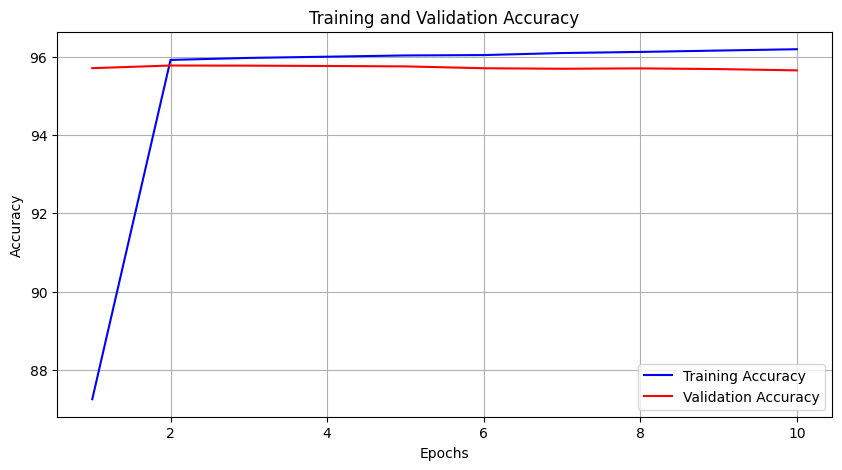

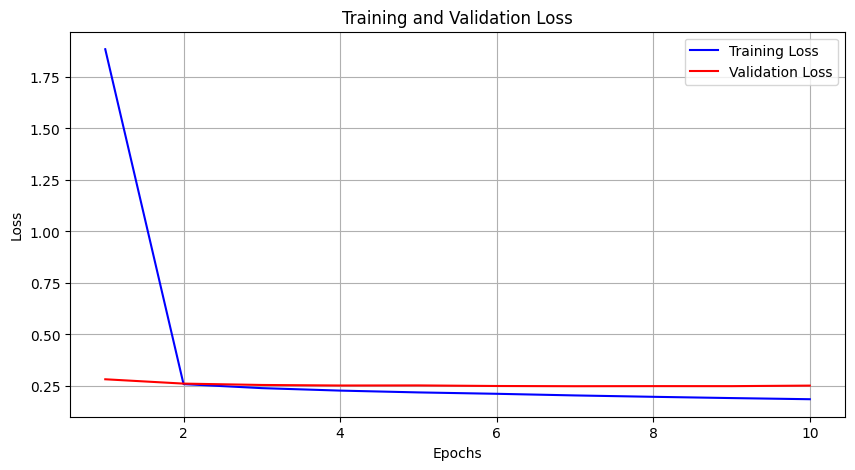

In [8]:
 # Configuration du logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

try:
    # Chargement des donnÃ©es
    df = pd.read_csv('c4200m.tsv', sep='\t')

    # Ã‰chantillonnage
    sampled_df = sample_c4200m_data(df, sample_size=5000)

    # EntraÃ®nement avec les donnÃ©es Ã©chantillonnÃ©es
    model, tokenizer = train_c4200m_model(
        sampled_df,
        output_dir=' bert-c4200m-m3',
        learning_rate=1e-5,
        batch_size=16,
        epochs=10,
        max_length=512,
    )

except Exception as e:
    logging.error(f"An error occurred: {str(e)}")
    raise e